In [2]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
import datetime
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

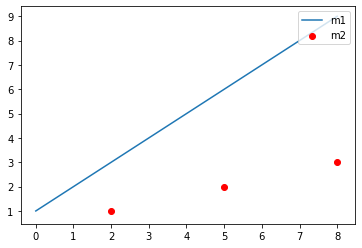

In [22]:
x = [1,2,3,4,5,6,7,8,9]
y = [1,2,3]
axis = np.arange(3-1,len(x),3)
plt.figure()
plt.plot(x)
plt.scatter(axis,y, c = 'red')
plt.legend(['m1','m2'], loc=1)

In [3]:
f = h5py.File("small.hdf5", "r")
num_songs = 5
temp = list(f)[:num_songs]
name = dict(zip(temp,np.arange(num_songs)))
name

{'10': 0, '140': 1, '141': 2, '148': 3, '2': 4}

In [29]:
Fs = 22050
LENGTH = Fs
channel = 1 #2**8
test = 0.7

def encode(batch):
    mu = np.float32(channel-1)
    safe_batch = np.minimum(abs(batch), 1.0)
    output = np.sign(batch) * np.log1p(mu * safe_batch) / np.log1p(mu)
    output = np.int32((output + 1) / 2 * mu + 0.5)
    output = np.eye(channel)[output]
    return output

def get_batch(f, k, training=0):
    
    batch = []
    label = []
    
    songs = np.random.choice(num_songs, k, replace=True)
    
    for i in range(len(songs)):
        cur_label = list(f)[songs[i]]
        if training == 0: # training for the first 70% data
            start = np.random.choice(int(len(f[cur_label])*test)-LENGTH, 1)[0]
        elif training == 1: # evaluation for the last 30% data
            start = np.random.choice(int(len(f[cur_label])*(1-test))-LENGTH, 1)[0] + int(len(f[cur_label])*test)
        else: # train on the whole dataset
            start = np.random.choice(len(f[cur_label])-LENGTH, 1)[0]
            
        segment = f[cur_label][start:start+LENGTH]
        batch.append(segment)
        label.append(name[cur_label])
        
    batch = np.asarray(batch).reshape(k,LENGTH,1)
    batch = batch/max(np.amax(batch),-np.amin(batch)) 
    #batch = encode(batch)
    label = np.asarray(label)
        
    return batch, label

In [36]:
train_data, train_label = get_batch(f,64,2)
train_label

array([25, 72, 13, 89, 69, 67, 73, 68, 66, 21,  8,  4, 11,  4, 36, 32,  2,
       98, 94, 37, 62, 22,  4, 13, 13, 21,  3, 57, 95, 75, 48, 54, 82,  4,
       67, 53,  6, 78,  5, 50, 95, 55, 45, 17, 96, 69, 42, 69, 54, 33, 28,
       15, 66,  3, 11, 18, 42, 68, 67, 22, 93, 27, 82, 28])

In [37]:
dilation_rates = [2**i for i in range(14)]
receptive_field = sum(dilation_rates)+2

def WaveNet(x):
    # save copy of input
    #original = x
    
    # discard last sample to preserve causality
    x = tf.slice(x, [0,0,0], [-1,LENGTH-1,-1])
    
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal",
        activation=tf.nn.relu)
    
    skips = []

    for dilation_rate in dilation_rates:
        
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field-1,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=32,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    out = tf.add_n(skips)
    out = tf.nn.relu(out)
    print(out)
    # postprocessing
    out = tf.layers.conv1d(
            inputs=out,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    out = tf.layers.conv1d(
            inputs=out,
            filters=channel,
            kernel_size=1,
            padding="same")

    # perform softmax
    print(out)
    out = tf.layers.max_pooling1d(out, 2, 2)
    out = tf.layers.flatten(out)
    print(out)
    out = tf.layers.dense(out, units=1024, activation=tf.nn.relu)
    
    # dropout layer
    out = tf.layers.dropout(
            inputs=out,
            rate=0.2)
    
    print(out)
    out = tf.layers.dense(out, units=1024, activation=tf.nn.relu)
    print(out)
    out = tf.layers.dense(out, units=num_songs)
    print(out)
    #prediction = tf.reshape(out, [-1,channel])
    #target = tf.slice(original, [0,receptive_field,0], [-1,-1,-1])
    #target = tf.reshape(target, [-1,channel])
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(
    #        logits=prediction,
    #        labels=target)
    #loss = tf.reduce_mean(loss)

    return out

In [4]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, LENGTH, channel])
input_label = tf.placeholder(tf.int32, [None])

# loss function operations
logits = WaveNet(input_data)
raw_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=input_label, logits=logits)
loss = tf.reduce_mean(raw_loss)

# evaluate
prediction = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(prediction, 1, output_type=tf.int32), input_label)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# train operation
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=0.001, 
                                           global_step=global_step, 
                                           decay_steps=100, 
                                           decay_rate=0.96, 
                                           staircase=True)
print(learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)#learning_rate)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)
init = tf.global_variables_initializer()

NameError: name 'LENGTH' is not defined

In [54]:
saver = tf.train.Saver(tf.trainable_variables())
sess = tf.Session()
sess.run(init)
loss_hist = []
accus = []
lrs = []
saver.restore(sess, "../model/WaveNet_medium.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../model/WaveNet_medium.ckpt


In [ ]:
num_epoch = 200
start = datetime.datetime.now()
for i in range(num_epoch):
    train_data, train_label = get_batch(f,64,2)
    _, loss_val, accu = sess.run([train_op, loss, accuracy],
                           feed_dict={input_data: train_data,
                                      input_label: train_label})
    #val_data, val_label = get_batch(f,64,1)
    #accu = sess.run([accuracy], feed_dict={input_data: val_data, input_label: val_label})[0]
    
    loss_hist.append(loss_val)
    accus.append(accu)
    #lrs.append(lr)
    if i % 50 == 0:
        print('iter num: '+str(i)+' loss: '+str(loss_hist[-1])+' accuracy: '+str(accus[-1]))#+' learning_rate: '+str(lr))

end = datetime.datetime.now()
print('time: '+str(end-start))

iter num: 0 loss: 2.1365263 accuracy: 0.375
iter num: 50 loss: 2.1102796 accuracy: 0.3125
iter num: 100 loss: 2.2413273 accuracy: 0.359375
iter num: 150 loss: 2.057078 accuracy: 0.359375


In [ ]:
save_path = saver.save(sess, "../model/WaveNet_medium.ckpt")
print("Model saved in path: %s" % save_path)
#length_44100 = accus

In [ ]:
start=0
plt.figure(figsize=(15,9))
plt.plot(loss_hist[start:])
plt.plot(accus[start:])
#plt.figure()
#plt.plot(lrs[start:])
plt.title('loss and accuracy')

In [ ]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 

In [27]:
tf.test.is_gpu_available()

True

0
1
2
3
4


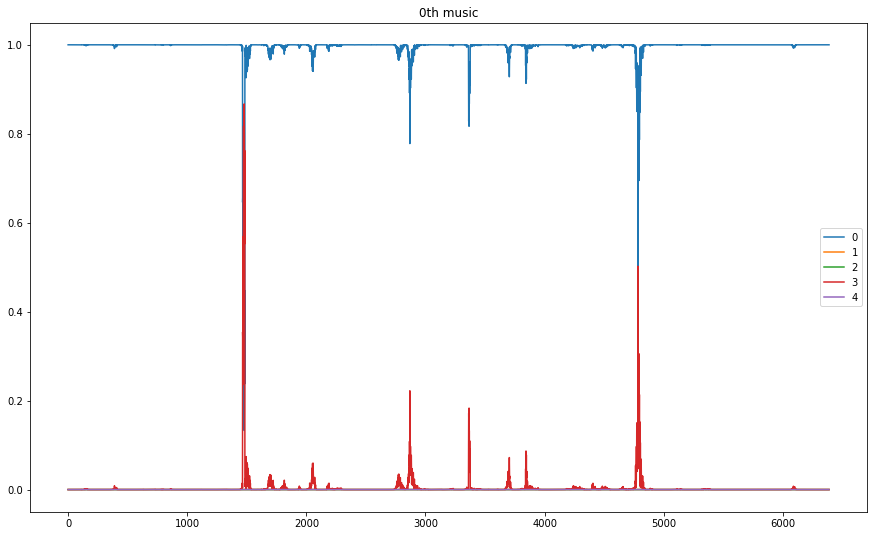

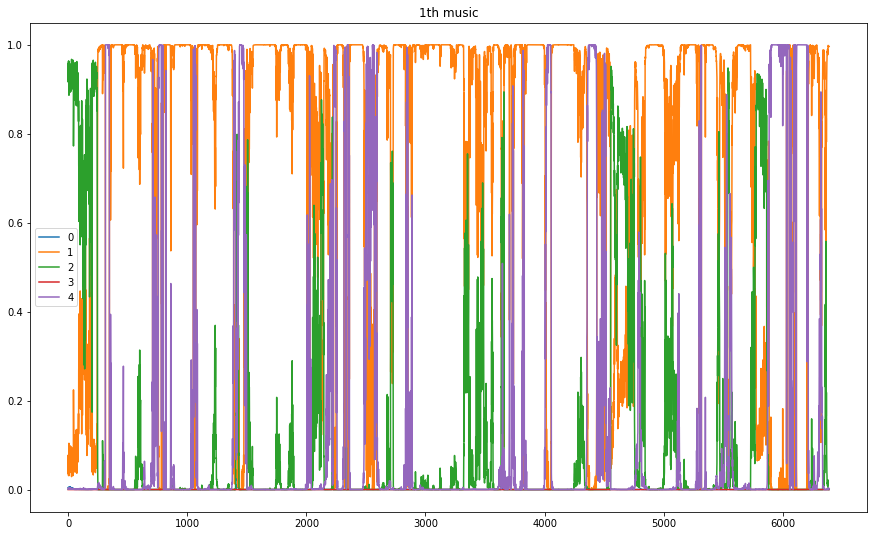

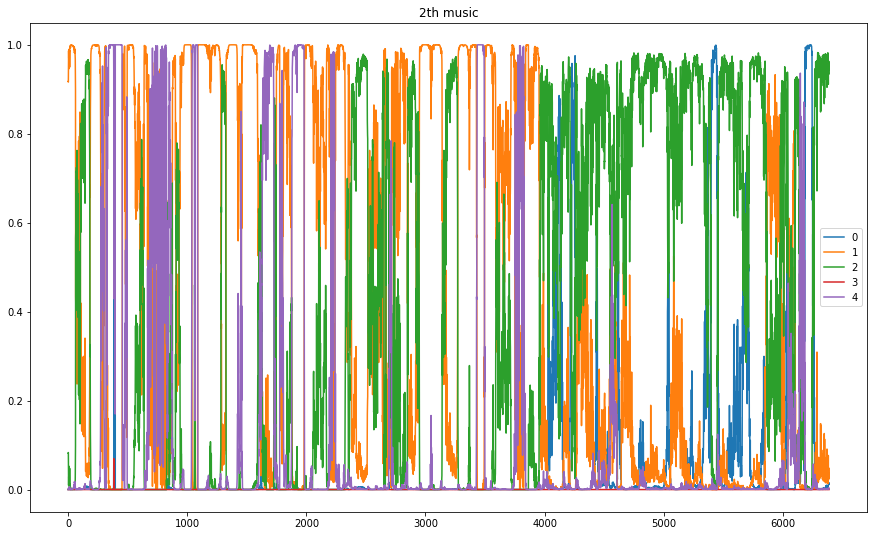

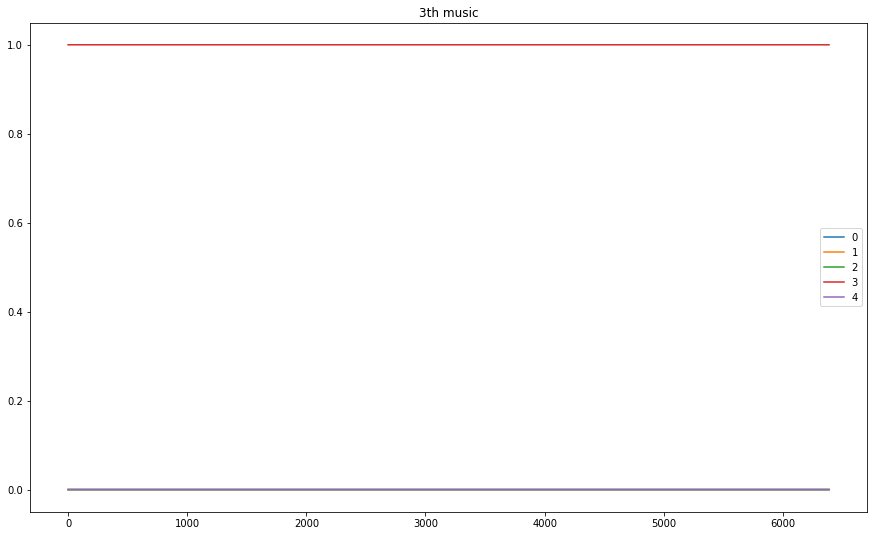

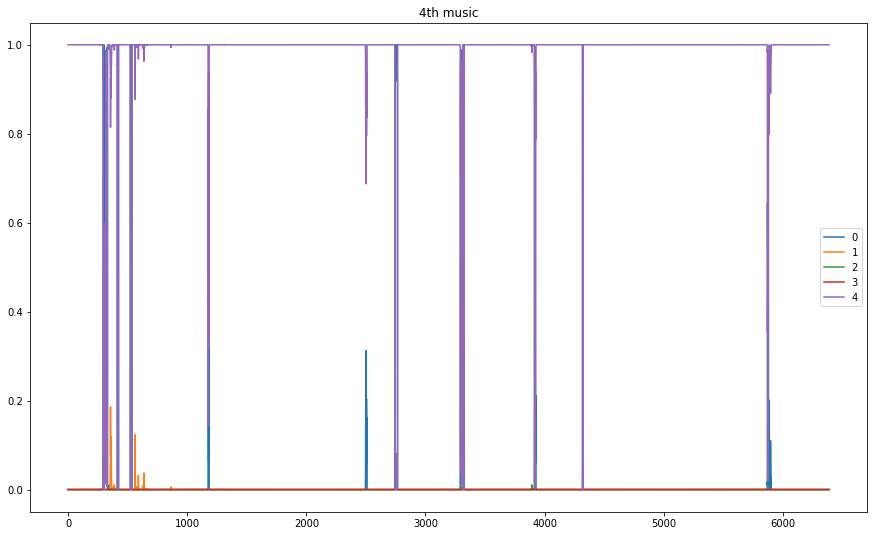

In [40]:
def recognize(audio):
    interval = 100
    num_fp = (len(audio)-LENGTH)//interval
    prob_curve = []
    for i in range(num_fp):
        train_data = audio[i*interval:i*interval+LENGTH]
        train_data = np.asarray(train_data).reshape(1,LENGTH,1)
        train_data = train_data/max(np.amax(train_data),-np.amin(train_data))
        prob = sess.run(prediction, feed_dict={input_data: train_data})[0]
        #if len(prob_curve) > 0:
            #prob = (np.sum(prob_curve, 0) + prob) / (len(prob_curve) + 1)
        prob_curve.append(prob)
    
    return np.transpose(np.asarray(prob_curve))
    
labels = list(f)[:5]
for i in range(5):
    print(i)
    curve = recognize(f[labels[i]])
    plt.figure(figsize=(15,9))
    plt.title(str(i)+'th music')
    for j in range(len(curve)):
        plt.plot(curve[j])
    plt.legend(np.arange(5))

In [34]:
f

['10', '140', '141', '148', '2']